# AB Testing Course - PA Bond

In [4]:
import pandas as pd
import numpy as np
import math
from statsmodels.stats import api as sms
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_1samp,shapiro,ttest_ind,mannwhitneyu,f_oneway,chi2_contingency
import seaborn as sns
from matplotlib            import pyplot as plt
import pingouin as pg

## 0.0 Planejamento

## 1.0 Design do Experimento

In [ ]:
# Imagina que o experimento ainda não aconteceu, então desenhamos ele como deveria acontecer

# Objetivo: Definir se o preenchumento automático da página de checkout é melhor do que o preenchimento manual
# Para escolher a métrica de sucesso é interessante trabalhar com algo que não apresenta um alto desvio padrão, pois isso pode influenciar no tamanho da amostra que precisa, o melhor é trabalhar com a conversão, se não tem, o número de compra e por fim o faturamento
# Métrica com dispersão naturalmente menor
# Conversão - (0 - 1)
# Compras - (0 - Unidades)
# GMV - (0 - Valor)
# Métrica: GMV (Gross Margin Revenue) Médio

# Grupo A = Preenchimento automático
# Grupo B = Preenchimento manual

### 1.1 Hipótese do Experimento

H0: Avg GMV A = Avg GMV B <br>
H1: Avg GMV A <> Avg GMV B

### 1.2 Definir o tamanho da amostra

In [109]:
p1 = 0.75
p2 = 0.80

#init_metric - métrica atual (média do gmv, média de vendas)
#end_metric - lift da métrica (5% sobre a métrica atual)
#std_metric - Desvio padrão dos valores
# lift = 0.05
# init_metric = 1902.86
# end_metric = init_metric*(1+lift)
# std_metric = 1398.89 

lift = 0.1
init_metric = 1874.18
end_metric = init_metric*(1+lift)
std_metric = 1305.25


#quanto maior, maior é a região de incerteza, o que tende a aumentar o número de amostras que precisa para provar o efeito

effect_size = (end_metric - init_metric)/std_metric

sample_size = np.ceil(sms.tt_ind_solve_power(
  effect_size = effect_size,
  alpha = 0.05,
  power = 0.8
)).astype(int)

print(sample_size)

763


## 2.0 Preparação dos dados

### 2.1 Loading Data

In [110]:
df_raw = pd.read_csv('../data/ab_testing.csv')

In [111]:
country = 'ESP'
df2 = df_raw.loc[df_raw['country'] == country,:]
df2.head()

,uid,country,gender,spent,purchases,date,group,device
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A
17,11149952,ESP,M,398,2,2017-02-02,GRP A,A
40,11183968,ESP,M,996,4,2016-04-01,GRP A,A
45,11193748,ESP,M,299,1,2016-10-11,GRP A,A
47,11199766,ESP,F,199,1,2017-05-04,GRP A,A


### 2.2 Descriptive Statistics

In [112]:
print(f'Number of rows: {df2.shape[0]}')
print(f'Number of columns: {df2.shape[1]}')

Number of rows: 1934
Number of columns: 8


In [113]:
df2.loc[:,['uid','group']].groupby('group').count().reset_index()

,group,uid
0,GRP A,970
1,GRP B,964


In [114]:
df2.loc[:,'spent'].agg(['mean','std'])

mean    1874.184592
std     1305.259136
Name: spent, dtype: float64

#### 2.2.1 Check NA

In [115]:
df2.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

#### 2.2.2 Check Unidade Experimental (pessoas)

In [116]:
df2.loc[:,['uid','group']].groupby('uid').count().reset_index().query('group > 1')

,uid,group


#### 2.2.3 Control and Treatment Homogenity

In [117]:
df2.loc[:,['uid','group','gender']].groupby(['gender','group']).count().reset_index()

,gender,group,uid
0,F,GRP A,493
1,F,GRP B,475
2,M,GRP A,477
3,M,GRP B,489


In [118]:
df2.loc[:,['uid','group','device']].groupby(['device','group']).count().reset_index()

,device,group,uid
0,A,GRP A,449
1,A,GRP B,491
2,I,GRP A,521
3,I,GRP B,473


In [119]:
df2.groupby('group').agg({'country':'count',
                          'spent':['min','max','mean','median','std'],
                          'purchases':['min','max','mean','median','std']})

country spent                                         purchases      \
        count   min   max         mean  median          std       min max   
group                                                                       
GRP A     970    99  8581  1794.191753  1497.0  1273.604015         1  19   
GRP B     964    99  8980  1954.675311  1696.0  1332.172125         1  20   

                                  
           mean median       std  
group                             
GRP A  4.364948    4.0  2.934934  
GRP B  4.764523    4.0  3.023540

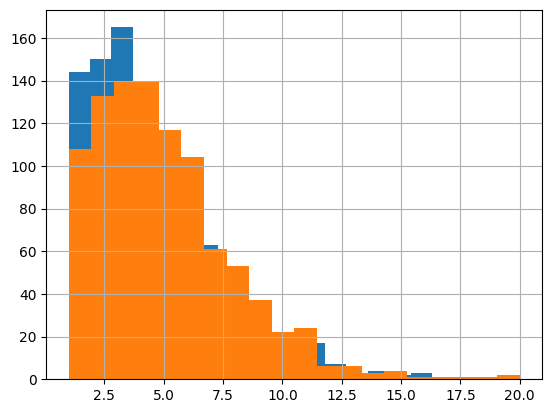

In [120]:
df2.loc[df2['group'] == 'GRP A','purchases'].hist(bins = 20);
df2.loc[df2['group'] == 'GRP B','purchases'].hist(bins = 20);
#Distribuições extremamente parecidas

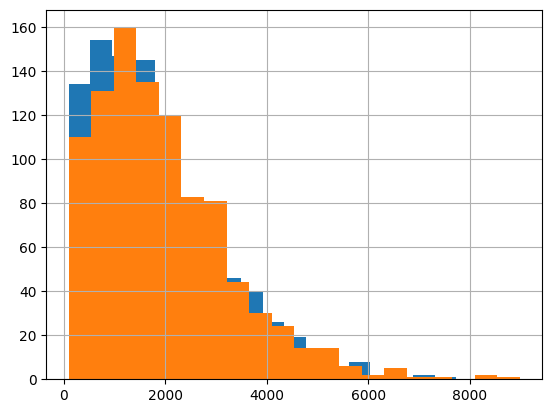

In [121]:
df2.loc[df2['group'] == 'GRP A','spent'].hist(bins = 20);
df2.loc[df2['group'] == 'GRP B','spent'].hist(bins = 20);
#Distribuições extremamente parecidas

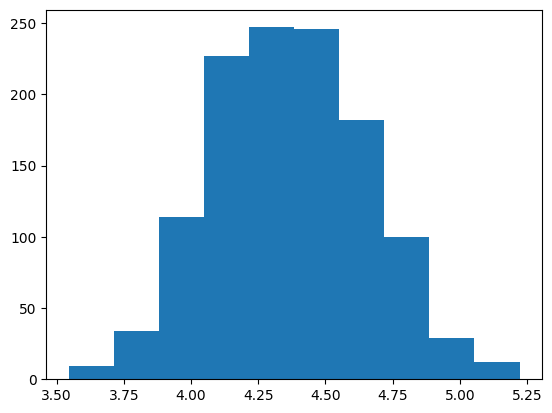

In [122]:
list_mean = []
#A distribuição da variável tem um perfil que não é uma normal, é um poassom, mas a média da amostragem tende a ser a normal
for i in range(1200):
  m = df2.loc[df2['group'] == 'GRP A','purchases'].sample(90).mean()
  list_mean.append(m)
plt.hist(list_mean);

## 3.0 Teste de Hipóteses

### 3.1 Groups

In [123]:
sample_A = df2.loc[df2['group'] == 'GRP A','spent'].sample(n=sample_size,random_state=42)
sample_B = df2.loc[df2['group'] == 'GRP B','spent'].sample(n=sample_size,random_state=42)

#Métricas
print(f'AVG Sample A: {round(sample_A.mean(),2)} +/- {round(sample_A.std(),2)}')
print(f'AVG Sample B: {round(sample_B.mean(),2)} +/- {round(sample_B.std(),2)}')

AVG Sample A: 1815.92 +/- 1271.61
AVG Sample B: 1950.69 +/- 1322.14


### 3.2 Inferência Estatística

In [124]:
z_value,p_value = ttest_ind(sample_A,sample_B)
print(f'p-value: {round(p_value,2)}')

p-value: 0.04


## 4.0 Conclusão

In [125]:
if p_value < 0.05:
  print(f'Rejeita a Hipótese nula')
  print(f'O preenchimento automático trouxe uma mudança significativa no GMV médio da página')
  print(f'Podemos liberar a página para toda a audiência do site')
else:
  print(f'Falha em rejeitar a hipótese nula')
  print(f'Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página')
  print(f'Repensar a estratéica do dispositivo de preenchumento automático')

Rejeita a Hipótese nula
O preenchimento automático trouxe uma mudança significativa no GMV médio da página
Podemos liberar a página para toda a audiência do site


In [126]:
#Próximos passos - Criar fazer uma EDA que mostre como os valores são aprecidos e criar uma função por país